#Downloading and Preparing CUHK Face Sketch Database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs

 99% 112M/113M [00:06<00:00, 22.7MB/s]
100% 113M/113M [00:06<00:00, 18.8MB/s]


In [ ]:
!unzip /content/cuhk-face-sketch-database-cufs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cropped_sketch/00726.jpg  
  inflating: cropped_sketch/00727.jpg  
  inflating: cropped_sketch/00728.jpg  
  inflating: cropped_sketch/00729.jpg  
  inflating: cropped_sketch/00730.jpg  
  inflating: cropped_sketch/00731.jpg  
  inflating: cropped_sketch/00732.jpg  
  inflating: cropped_sketch/00733.jpg  
  inflating: cropped_sketch/00734.jpg  
  inflating: cropped_sketch/00735.jpg  
  inflating: cropped_sketch/00736.jpg  
  inflating: cropped_sketch/00737.jpg  
  inflating: cropped_sketch/00738.jpg  
  inflating: cropped_sketch/00739.jpg  
  inflating: cropped_sketch/00740.jpg  
  inflating: cropped_sketch/00741.jpg  
  inflating: cropped_sketch/00742.jpg  
  inflating: cropped_sketch/00743.jpg  
  inflating: cropped_sketch/00744.jpg  
  inflating: cropped_sketch/00745.jpg  
  inflating: cropped_sketch/00746.jpg  
  inflating: cropped_sketch/00747.jpg  
  inflating: cropped_sketch/00749.jpg  
  inflating: cropped_sketch/0

#Importing the Necessary Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os
import re
import random
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, Dropout, Input, LeakyReLU
from keras.preprocessing.image import img_to_array
from keras import Model
import matplotlib.pyplot as plt
from tqdm import tqdm

#Setting Up Paths and Variables

In [ ]:
image_path = '/content/photos'
sketch_path = '/content/sketches'

image_array = []
sketch_array = []

IMAGE_SIZE = 224

#Sorting Image and Sketch Files for Processing

In [ ]:
def sort_image(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=alphanum_key)

image_files = sort_image([os.path.join(image_path, f) for f in os.listdir(image_path)])
sketch_files = sort_image([os.path.join(sketch_path, f) for f in os.listdir(sketch_path)])

#Image Processing and Augmentation

In [ ]:
def process_and_augment_images(image_files, data_array):

    for file in tqdm(image_files):
        image = cv2.imread(file, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image.astype('float32') / 255.0

        data_array.append(img_to_array(image))

        horizontal_flip = cv2.flip(image, 1)
        vertical_flip = cv2.flip(image, -1)
        horizontal_vertical_flip = cv2.flip(horizontal_flip, 0)

        rotated_clockwise = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        rotated_clockwise_flip = cv2.flip(rotated_clockwise, 1)

        rotated_counter_clockwise = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        rotated_counter_clockwise_flip = cv2.flip(rotated_counter_clockwise, 1)

        augmented_images = [
            horizontal_flip, vertical_flip, horizontal_vertical_flip,
            rotated_clockwise, rotated_clockwise_flip,
            rotated_counter_clockwise, rotated_counter_clockwise_flip
        ]

        for augmented_image in augmented_images:
            data_array.append(img_to_array(augmented_image))


process_and_augment_images(image_files, image_array)
process_and_augment_images(sketch_files, sketch_array)

print(f'\nNumber of augmented images: {len(image_array)}')
print(f'Number of augmented sketches: {len(sketch_array)}')

100%|██████████| 188/188 [00:00<00:00, 250.54it/s]


Number of augmented images: 1504
Number of augmented sketches: 1504


#Visualizing Images and Sketches

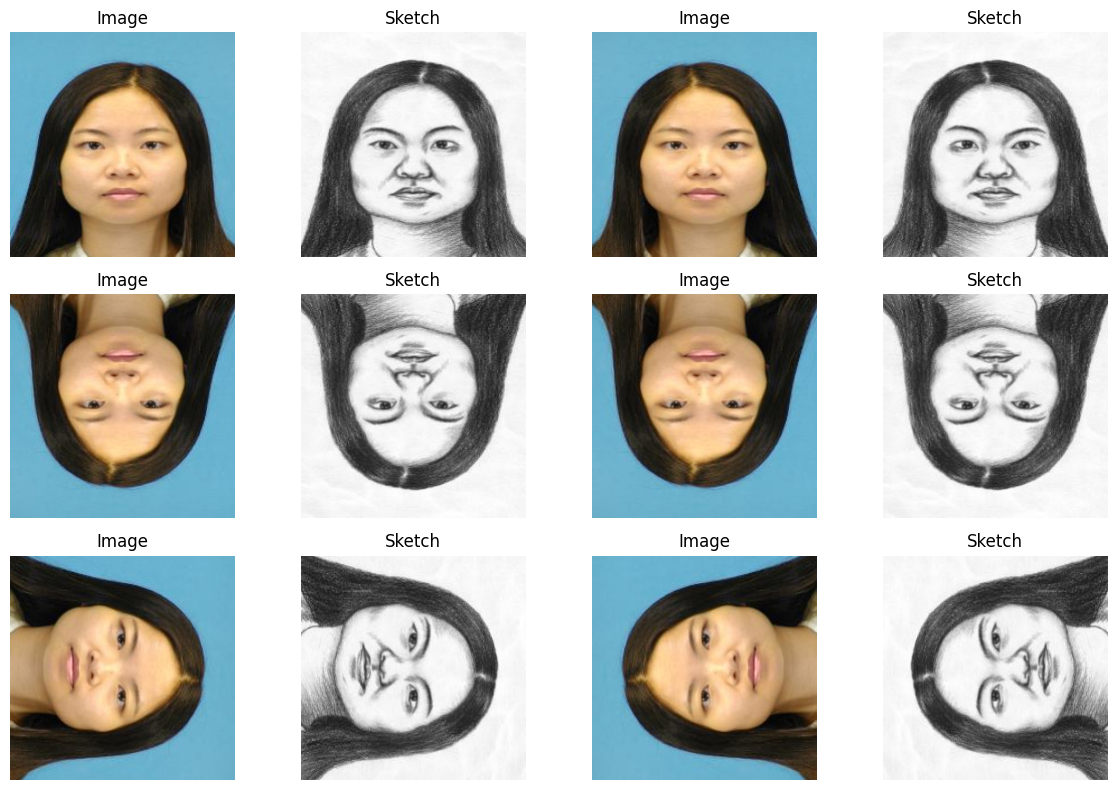

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(6):
    row = i // 2
    col = i % 2

    axes[row, col * 2].imshow(image_array[i])
    axes[row, col * 2].set_title("Image")
    axes[row, col * 2].axis('off')

    axes[row, col * 2 + 1].imshow(sketch_array[i], cmap='gray')
    axes[row, col * 2 + 1].set_title("Sketch")
    axes[row, col * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

#Splitting and Reshaping the Dataset for Training and Testing

In [ ]:
sketch_array = np.array(sketch_array)
image_array = np.array(image_array)

train_sketch_image, test_sketch_image, train_image, test_image = train_test_split( sketch_array, image_array, test_size=0.2, random_state=42)

train_sketch_image = train_sketch_image.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
train_image = train_image.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
print('Train image shape:', train_image.shape)

test_sketch_image = test_sketch_image.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
test_image = test_image.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
print('Test image shape:', test_image.shape)

Train image shape: (1203, 224, 224, 3)
Test image shape: (301, 224, 224, 3)


#Autoencoder

##Autoencoder Architecture

In [ ]:
encoder_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(filters = 16, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(filters = 64, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(filters = 128, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(filters = 256, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(filters = 512, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
encoder_output = LeakyReLU()(x)

decoder_input = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(encoder_output)
x = Dropout(0.1)(decoder_input)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = Dropout(0.1)(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = Dropout(0.1)(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 32, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = Dropout(0.1)(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 16, kernel_size = (4,4), strides = 2, use_bias = False, kernel_initializer = 'he_normal')(x)
x = Dropout(0.1)(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 8, kernel_size = (2,2),strides = (1,1), padding = 'valid')(x)
x = Dropout(0.1)(x)
x = LeakyReLU()(x)
decoder_output = Conv2DTranspose(filters = 3,kernel_size = (2,2),strides = (1,1), padding = 'valid')(x)

model= Model(encoder_input, decoder_output)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 111, 111, 16)      768       
                                                                 
 batch_normalization (Batch  (None, 111, 111, 16)      64        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 111, 111, 16)      0         
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 64)        16384     
                                                             

##Training the Model

In [ ]:
model.fit(train_image, train_sketch_image, epochs = 100, batch_size=16)

Epoch 1/100
76/76 [==============================] - 35s 134ms/step - loss: 0.3385 - acc: 0.2513
Epoch 2/100
76/76 [==============================] - 9s 118ms/step - loss: 0.1790 - acc: 0.3175
Epoch 3/100
76/76 [==============================] - 9s 120ms/step - loss: 0.1541 - acc: 0.3038
Epoch 4/100
76/76 [==============================] - 9s 122ms/step - loss: 0.1395 - acc: 0.2964
Epoch 5/100
76/76 [==============================] - 9s 120ms/step - loss: 0.1295 - acc: 0.3015
Epoch 6/100
76/76 [==============================] - 9s 119ms/step - loss: 0.1203 - acc: 0.3126
Epoch 7/100
76/76 [==============================] - 9s 119ms/step - loss: 0.1142 - acc: 0.3176
Epoch 8/100
76/76 [==============================] - 9s 117ms/step - loss: 0.1081 - acc: 0.3229
Epoch 9/100
76/76 [==============================] - 9s 121ms/step - loss: 0.1051 - acc: 0.3200
Epoch 10/100
76/76 [==============================] - 9s 118ms/step - loss: 0.1004 - acc: 0.3173
Epoch 11/100
76/76 [==================

##Evaluating Autoencoder Model on Test Data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_image, test_sketch_image)

print("Test Loss:", test_loss)
print("Test Accuracy:", f"{np.round(test_accuracy * 100, 2)}%")

10/10 [==============================] - 3s 162ms/step - loss: 0.0691 - acc: 0.9801
Test Loss: 0.06912695616483688
Test Accuracy: 98.01%


##Displaying Original, Sketch, and Predicted Images

1/1 [==============================] - 1s 877ms/step


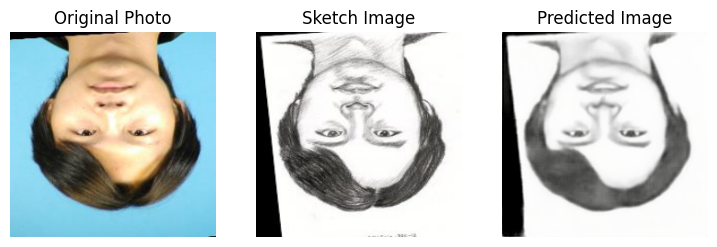

1/1 [==============================] - 0s 37ms/step


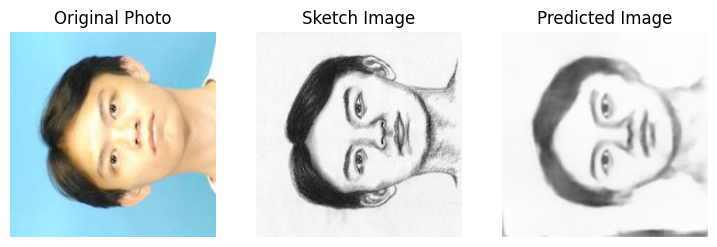

1/1 [==============================] - 0s 30ms/step


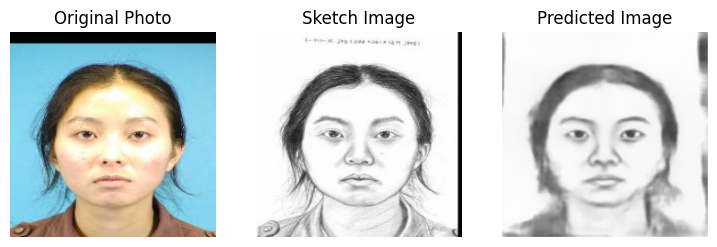

1/1 [==============================] - 0s 31ms/step


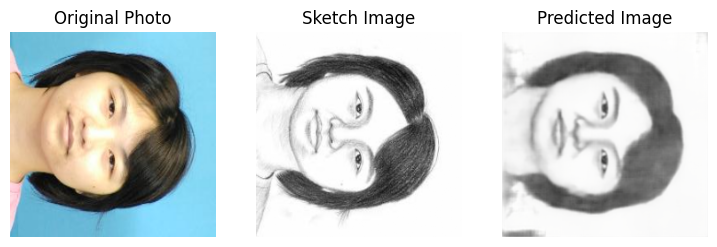

1/1 [==============================] - 0s 36ms/step


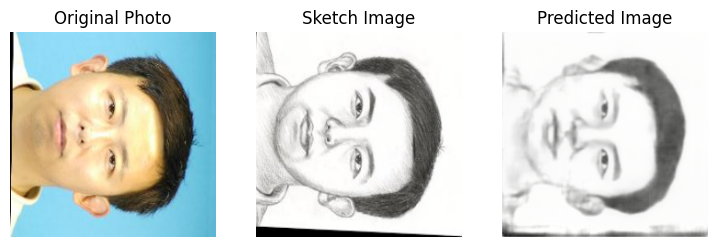

1/1 [==============================] - 0s 32ms/step


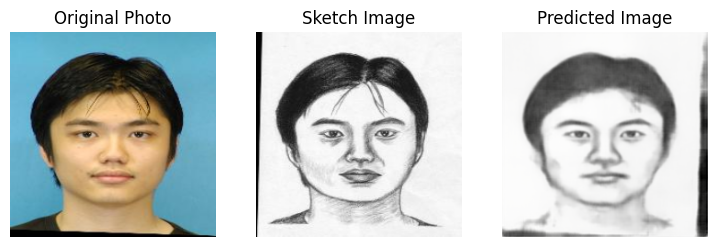

In [ ]:
def display_images(original_img, sketch_img, predicted_img):
    original_img = np.clip(original_img, 0.0, 1.0)
    sketch_img = np.clip(sketch_img, 0.0, 1.0)
    predicted_img = np.clip(predicted_img, 0.0, 1.0)
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Photo')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sketch_img, cmap='gray')
    plt.title('Sketch Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_img)
    plt.title('Predicted Image')
    plt.axis('off')

    plt.show()

num_samples_to_display = 6
random_indices = random.sample(range(len(test_image)), num_samples_to_display)

for index in random_indices:
    original_img = test_image[index]
    sketch_img = test_sketch_image[index]
    predicted_img = model.predict(original_img.reshape(1, 224, 224, 3)).reshape(224, 224, 3)

    display_images(original_img, sketch_img, predicted_img)